# MIE 1624 Final Project - Group 1

In [1]:
#!git clone https://github.com/angrycircuit/group1-project.git
#%cp -r group1-project/job_data .
#%cp -r group1-project/skill_lists .
#%cp -r group1-project/courses_data .

Cloning into 'group1-project'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 318 (delta 9), reused 1 (delta 0), pack-reused 300
Receiving objects: 100% (318/318), 9.74 MiB | 6.59 MiB/s, done.
Resolving deltas: 100% (158/158), done.


### Import Libraries 

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import csv
import os
import random
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns

# for dendrogram
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.cluster.hierarchy import ward, dendrogram

import nltk
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
#!git config --global credential.helper wincred
#!git clone https://github.com/angrycircuit/mie1624-group1-project

## Data Preparation

### Read job data

In [4]:
df_indeed = pd.read_csv('job_data/indeed.csv')
df_work = pd.read_csv('job_data/workopolis.csv')
df_monster = pd.read_csv('job_data/monster.csv')

### Combine job data

In [5]:
df_job = pd.concat([df_indeed, df_work, df_monster], axis = 0)

# drop duplicates if 'location', 'company' and 'job_title' are the same
df_job.drop_duplicates(subset=['location', 'company','job_title'], keep='last')

# reset index and drop old index columns
df_job = df_job.reset_index()
df_job = df_job.drop(["index","Unnamed: 0"],axis=1)

df_job

,location,company,job_title,salary,job_description,job_url
0,"Mississauga, ON",Hatch,Data Scientist,NaN,Requisition ID: 33710\nJob Category: Informati...,NaN
1,"Toronto, ON",Loopio,Data Scientist,NaN,Loopio is a workplace that unleashes learning ...,NaN
2,"Waterloo, ON",McAfee,Data Scientist,NaN,"Job Title:\nData Scientist\n\nLocation:\nUS, T...",NaN
3,"Montréal, QC",EXFO,Data Scientist,NaN,Job title: Data Scientist\nDivision/function: ...,NaN
4,"Montréal, QC",Canadian National Railway,Data Scientist,NaN,Job Summary\nThe Data Scientist is responsible...,NaN
...,...,...,...,...,...,...
1667,"Montreal, QC",Fednav Limited,Coordonnateur de projet en TI,NaN,descriptionqui nous sommes | l’entrepriseétabl...,https://job-openings.monster.ca/coordonnateur-...
1668,"Milton, ON",Magna International Inc.,Ecoat Operator,NaN,descriptiongroup description cosma provides a ...,https://job-openings.monster.ca/ecoat-operator...
1669,"Calgary, AB",Calgary Co-operative Association Limited,Bakery Manager,NaN,"descriptionabout us owned by our members, calg...",https://job-openings.monster.ca/bakery-manager...
1670,"Sault Ste. Marie, ON",Ferrovial Services,"Seasonal Equipment Operator - Thessalon, Goula...",NaN,description about us ferrovial services north ...,https://job-openings.monster.ca/seasonal-equip...


### Target skill list

In [6]:
# import skills from 'programming_language.csv'
df_programming_language = pd.read_csv('skill_lists/programming_language.csv')
programming_language_skill = df_programming_language['skill'].to_list()

# import skills from 'ibm_skills_manual.txt'
ibm_skills_manual_txt = open('skill_lists/ibm_skills_manual.txt', 'r')
ibm_skill = ibm_skills_manual_txt.read().splitlines()

# import skills from 'business_skill.txt'
business_skill_txt = open('skill_lists/business_skill.txt', 'r')
business_skill = business_skill_txt.read().splitlines()

# import skills from 'technical_skill.txt'
technical_skill_txt = open('skill_lists/technical_skill.txt', 'r')
technical_skill = technical_skill_txt.read().splitlines()

# import skills from 'technical_skill.txt'
coursera_skill_txt = open('skill_lists/top_100_coursera_skills.txt', 'r')
coursera_skill = coursera_skill_txt.read().splitlines()


# combine skills 
skills = ibm_skill + programming_language_skill + business_skill + technical_skill + coursera_skill

# lowercase
skills = [skill.lower() for skill in skills]

# remove duplicates
res = [] 
[res.append(x) for x in skills if x not in res] 
skills = res

# remove specific skills
# preform the operation here instead of manually in the txt or csv
# terms that are too general or too vague
to_remove = ['processing',
             'transform',
             'jobs',
             'debugging',
             'b',
             's',
             'bc',
             'self',
             't',
             'e']

skills = [skill for skill in skills if skill not in to_remove]

# add columns for skills
for skill in skills:
      df_job[skill] = np.zeros(len(df_job))

### Extract skills from jobs

In [7]:
%%time
for i in range(len(df_job)):
 
    text = str(df_job.iloc[i]['job_description']).strip().lower()
    
    # Preprocessing, replace punctuations, and replace multiple spaces
    text = re.sub(r'\,', ' ', text) 
    text = re.sub('/', ' ', text) 
    text = re.sub(r'\(', ' ', text) 
    text = re.sub(r'\)', ' ', text) 
    text = re.sub(' +',' ',text) 

    for s in skills :
        # This is specifically for C++, escape the ++. Convert C++ to C\+\+
        if any(x in s for x in ['+']):
            skill = re.escape(s)
        else:
            skill = s
    
        matching = re.search(r'(?:^|(?<=\s))' + skill + r'(?=\s|$)',text)
        if matching:
      
            df_job[s][i] = 1
df_job      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 7min 42s, sys: 81.6 ms, total: 7min 42s
Wall time: 7min 42s


## Job skill frequency

### Drop zero-frequency skills

In [8]:
# extract skills only
df_skill = df_job[skills]

# drop skills with 0 appearance
cols = (np.sum(df_skill) != 0)
df_skill_clean = df_skill[cols[cols].index]

### Merge identical meaning columns

In [9]:
def to_one_helper(x): 
    # convert the value larger than 1 to 1
    if x > 1:
        x = 1
    return x

def merge_helper(c1,c2): 
    # merge columns whose names have identical meanings 
    # merge c2 into c1
    df_skill_clean[c1] += df_skill_clean[c2]
    df_skill_clean[c1] = df_skill_clean[c1].apply(lambda x: to_one_helper(x))
    del df_skill_clean[c2]

In [10]:
merge_helper('java','javascript')
merge_helper('machine learning','ml')
merge_helper('natural language processing','nlp')
merge_helper('communication','communicate')
merge_helper('communication','inform')
merge_helper('insights','analyze')
merge_helper('sql','mysql')
merge_helper('sql','postgresql')
merge_helper('c++','c')
merge_helper('statistics','statistical')
merge_helper('statistics','statistical analysis')
merge_helper('data analysis','analytics')
merge_helper('data analysis','data science')
merge_helper('research','business intelligence')
merge_helper('modelling','forecasting')
merge_helper('modelling','validate')
merge_helper('data management','organize')
merge_helper('project management','time management')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Skill frequency

In [11]:
# count skill appearance
skill_count = df_skill_clean.sum()
skill_count = skill_count.sort_values(ascending=False)
df_skill_count = pd.DataFrame(data=skill_count,columns=["Count"])
df_skill_count.index.name = "Skill"
df_skill_count.head(50)

,Count
Skill,
communication,937.0
data analysis,856.0
machine learning,697.0
python,690.0
insights,575.0
research,559.0
statistics,555.0
sql,467.0
r,322.0


# Dataframe that only contains skills (for clustering etc.)

In [12]:
df_skill_clean

,sampling,probability,distributions,inferential,visualize,insights,characterize,formulate,hypothesis,manipulate,clean data,outliers,data normalization,linear algebra,machine learning,modeling techniques,model validation,big data,a.net,accent,actionscript,ada,ampl,apt,arc,bash,beanshell,c++,c#,cg,charm,claire,clojure,cobol,compass,cool,crystal,d,dc,dcl,...,cloud databases,deep learning,linear regression,random forest,scikit-learn,exploratory data analysis,predictive modelling,apache spark,computer programming,jupyter notebook,data structure,text mining,statistical inference,web scraping,probability and statistics,computer vision,microsoft excel,predictive analytics,business analytics,decision tree,recommender systems,mathematical optimization,data management,data mining,cloud computing,business analysis,reinforcement learning,python libraries,feature engineering,relational database,bigquery,data warehousing,time series,bayesian statistics,spreadsheet,intelligent systems,machine-learning,dimensionality reduction,privacy,business strategy
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167

### Skill demand visualization

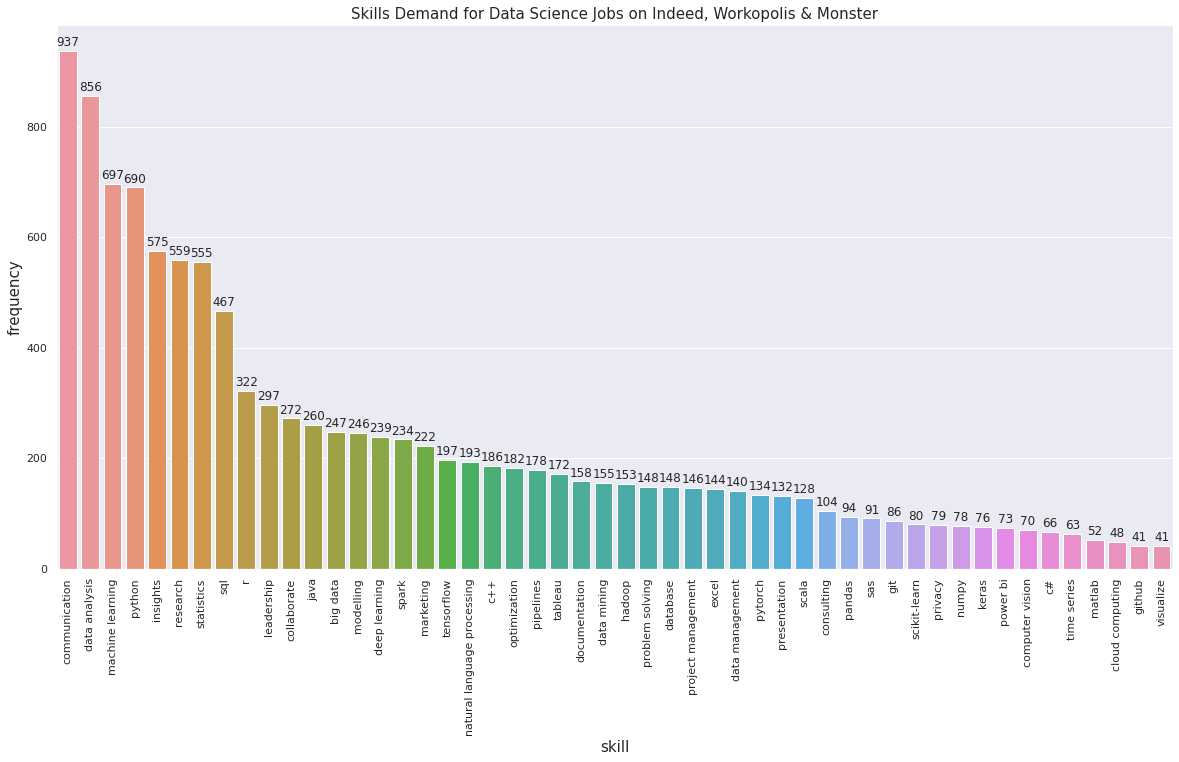

<Figure size 1440x720 with 0 Axes>

In [27]:
df_skill_count_50 = df_skill_count.head(50)
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x = df_skill_count_50.index, y = df_skill_count_50['Count'])
plt.xlabel('skill', fontsize = 15)
plt.ylabel('frequency', fontsize = 15)
plt.title('Skills Demand for Data Science Jobs on Indeed, Workopolis & Monster', fontsize = 15)
plt.xticks(rotation = 'vertical')

for x,y in zip(np.arange(0,df_skill_count_50.shape[0],1),df_skill_count_50['Count']):
    label = "{:.0f}".format(y)
    plt.annotate(label, (x,y),textcoords='offset points',xytext=(0,5), ha='center') 

plt.show()

plt.savefig('skills50.png')

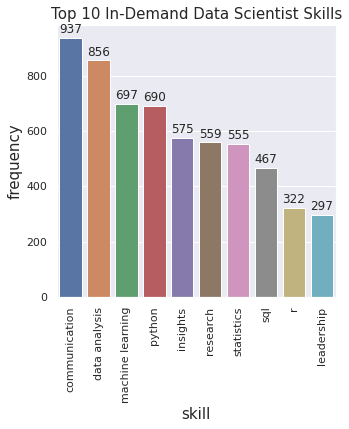

In [41]:
df_skill_count_plot = df_skill_count.head(10)
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(x = df_skill_count_plot.index, y = df_skill_count_plot['Count'])
plt.xlabel('skill', fontsize = 15)
plt.ylabel('frequency', fontsize = 15)
plt.title('Top 10 In-Demand Data Scientist Skills', fontsize = 15)
plt.xticks(rotation = 'vertical')

for x,y in zip(np.arange(0,df_skill_count_plot.shape[0],1),df_skill_count_plot['Count']):
    label = "{:.0f}".format(y)
    plt.annotate(label, (x,y),textcoords='offset points',xytext=(0,5), ha='center') 

plt.savefig('skills10.png')
plt.show()

### Top 20 skills

In [23]:
skill_1624 = df_skill_count.head(20).index
skill_1624

Index(['communication', 'data analysis', 'machine learning', 'python',
       'insights', 'research', 'statistics', 'sql', 'r', 'leadership',
       'collaborate', 'java', 'big data', 'modelling', 'deep learning',
       'spark', 'marketing', 'tensorflow', 'natural language processing',
       'c++'],
      dtype='object', name='Skill')

## Clusting and Dendrogram

In [28]:
dendrogram_df = df_skill_clean[df_skill_count_50.index]

corr_matrix = dendrogram_df.corr()
corr_matrix

,communication,data analysis,machine learning,python,insights,research,statistics,sql,r,leadership,collaborate,java,big data,modelling,deep learning,spark,marketing,tensorflow,natural language processing,c++,optimization,pipelines,tableau,documentation,data mining,hadoop,problem solving,database,project management,excel,data management,pytorch,presentation,scala,consulting,pandas,sas,git,scikit-learn,privacy,numpy,keras,power bi,computer vision,c#,time series,matlab,cloud computing,github,visualize
communication,1.000000,0.101952,0.013189,0.059524,0.184593,0.124477,0.173938,0.113582,0.148357,0.118416,0.135721,-0.038924,-0.004824,0.119535,-0.037654,-0.017836,0.069565,-0.046347,0.003173,-0.058387,0.015499,0.028316,0.089684,0.088384,0.104442,0.021974,0.148734,0.004496,0.103214,0.087198,0.098071,-0.027048,0.120771,-0.007850,0.073430,-0.003548,0.085004,-0.039251,0.057401,0.055248,-0.026922,-0.020773,0.053606,-0.037473,0.018647,0.029707,-0.021805,0.029590,-0.038774,0.015764
data analysis,0.101952,1.000000,0.437220,0.441713,0.429786,0.316564,0.490034,0.439804,0.361533,0.137581,0.193695,0.177934,0.291839,0.243392,0.142349,0.245557,0.149311,0.119294,0.083095,-0.000856,0.168355,0.181832,0.283355,0.053625,0.241954,0.181222,0.038879,0.169464,0.051935,0.013978,0.118039,0.089886,0.117235,0.186616,0.162276,0.175964,0.202595,0.054014,0.151598,0.031327,0.142221,0.103918,0.185193,-0.016950,0.062742,0.155496,0.099104,0.089036,0.092910,0.131592
machine learning,0.013189,0.437220,1.000000,0.552825,0.266363,0.298206,0.411230,0.209063,0.251543,0.051387,0.176212,0.256464,0.191564,0.162493,0.437962,0.270814,-0.034119,0.394612,0.347527,0.244834,0.203039,0.227323,0.033139,0.004707,0.223298,0.240734,-0.037138,0.026921,-0.072458,-0.125517,0.007177,0.313366,0.062861,0.185419,0.013289,0.214939,0.069863,0.099674,0.248080,0.006104,0.204110,0.246446,-0.032243,0.156381,0.158777,0.163959,0.142019,0.196071,0.093402,0.124775
python,0.059524,0.441713,0.552825,1.000000,0.329176,0.284070,0.448786,0.363589,0.434752,0.023630,0.173636,0.307424,0.185115,0.210848,0.331012,0.320163,0.033600,0.353083,0.248461,0.298429,0.214111,0.266043,0.160035,0.015768,0.205400,0.235360,0.003950,0.059550,-0.087147,-0.045146,0.088705,0.298440,0.060938,0.265815,0.030589,0.212057,0.130912,0.145800,0.250352,0.042361,0.246615,0.231167,0.058706,0.164454,0.129540,0.172262,0.185741,0.183271,0.142017,0.118452
insights,0.184593,0.429786,0.266363,0.329176,1.000000,0.268927,0.396083,0.349111,0.332920,0.088492,0.117559,0.015935,0.096011,0.211137,0.071255,0.107161,0.139718,0.047849,0.057637,-0.039905,0.167409,0.080774,0.223187,0.050205,0.207071,0.123948,0.080246,0.084679,0.012447,0.042540,0.085706,0.055265,0.105551,0.042529,0.063781,0.113004,0.148220,0.019522,0.120860,0.028675,0.066725,0.035444,0.178050,0.024688,-0.010976,0.081558,0.116904,0.033877,-0.025236,0.170149
research,0.124477,0.316564,0.298206,0.284070,0.268927,1.000000,0.302731,0.180473,0.235810,0.115115,0.161661,0.028247,0.108691,0.185228,0.174205,0.116083,0.088840,0.114577,0.164550,0.047636,0.167511,0.108885,0.118917,0.009430,0.092582,0.021314,0.033560,0.087120,-0.030593,-0.023244,0.055812,0.155020,0.102814,0.034358,0.037950,0.102223,0.126166,-0.015798,0.096542,0.021439,0.107742,0.021856,0.071933,0.136708,0.090724,0.066160,0.062917,0.083151,0.026989,0.067975
statistics,0.173938,0.490034,0.411230,0.448786,0.396083,0.302731,1.000000,0.322670,0.431965,0.074484,0.143544,0.023469,0.111001,0.295232,0.198365,0.162271,0.117188,0.128458,0.166682,0.085872,0.214445,0.082009,0.242093,0.011088,0.405303,0.146303,0.057561,0.079918,0.002416,0.014491,0.121643,0.124054,0.118616,0.074097,0.086654,0.120188,0.233984,-0.008893,0.127606,0.040567,0.133149,0.090074,0.122872,-0.033201,0.085394,0.227361,0.166372,0.091780,0.077114,0.167445
sql,0.113582,0.439804,0.209063,0.363589,0.349111,0.180473,0.322670,1.000000,0.280801,0.045502,0.130132,0.159578,0.296837,0.208070,0.031405,0.236851,0.086403,0.053656,-0.003780,-0.054906,0.103434,0.187077,0.385973,0.081434,0.233076,0.

In [29]:
corr_target = abs(corr_matrix)
#relevant_features = cor_target[cor_target<1.0][cor_target>0.5]
#ensure only correlated skills are plotted
relevant_skills = corr_target[corr_target<1.0]

relevant_skills.dropna(how='all', inplace=True)
print('Relevant_skills count = ', len(relevant_skills))

Relevant_skills count =  50


Text(156.5, 0.5, 'Skills')

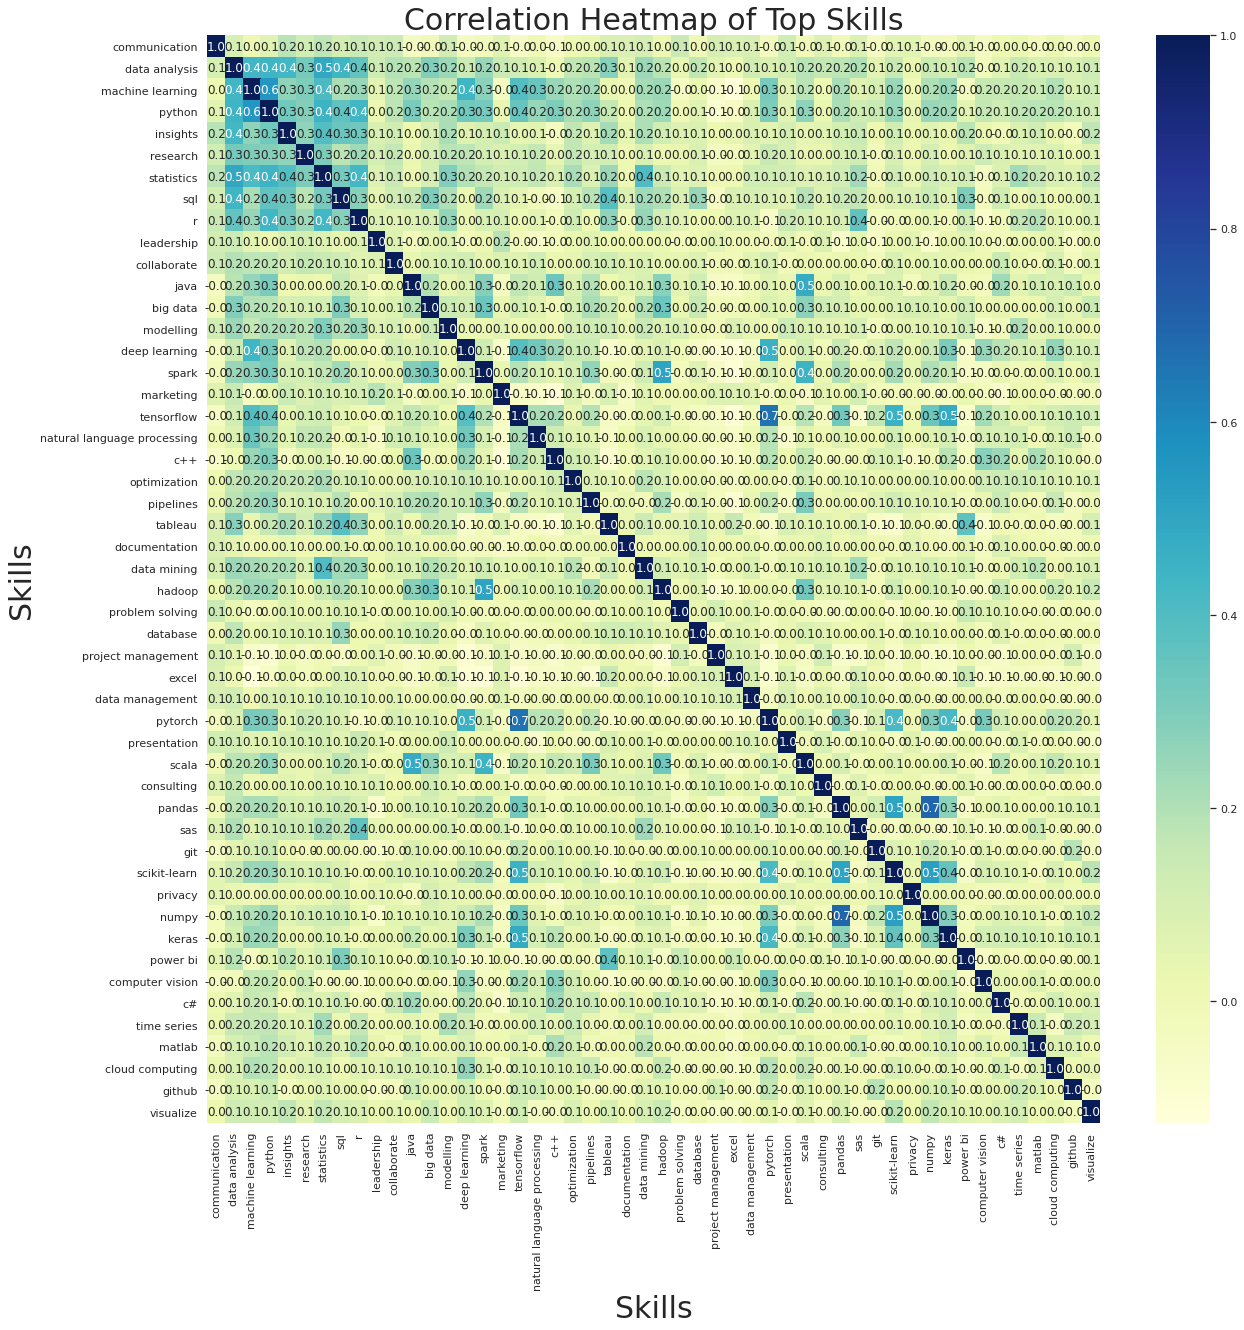

In [30]:
plt.figure(figsize=(20,20))

ax = sns.heatmap(dendrogram_df[relevant_skills.index].corr(),
                 annot = True,
                 fmt = '.1f',
                 cmap = "YlGnBu")
ax.set_title("Correlation Heatmap of Top Skills", fontsize = 30)
ax.set_xlabel("Skills", fontsize = 30)
ax.set_ylabel("Skills", fontsize = 30)

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


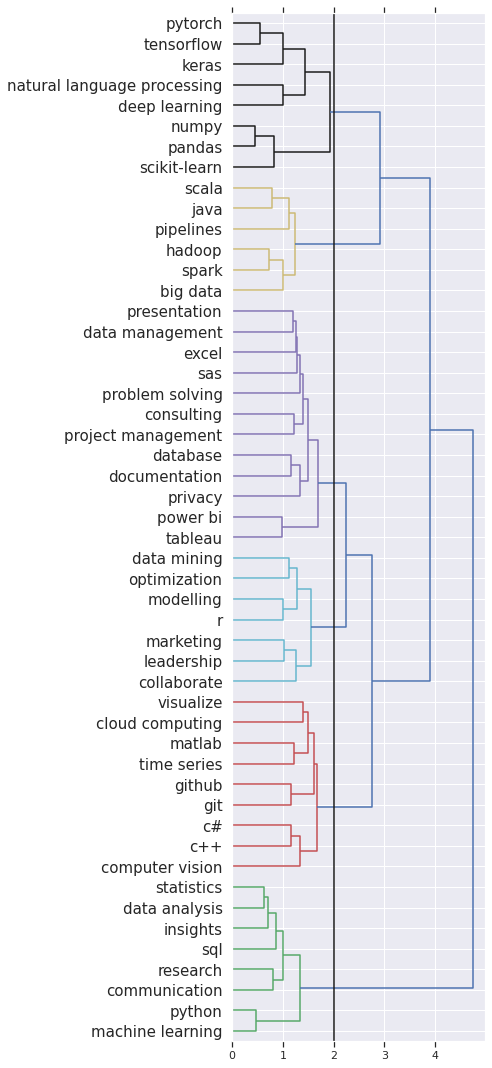

In [35]:
dist = pairwise_distances(dendrogram_df[relevant_skills.index].T, metric = 'cosine')

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
cutoff_line = 2.0

fig, ax = plt.subplots(figsize=(7, 15)) # set size
ax = dendrogram(linkage_matrix,
                orientation="right",
                labels = dendrogram_df[relevant_skills.index].T.index,
                color_threshold = cutoff_line);
plt.axvline(x = cutoff_line, c='k')
plt.tick_params(\
    axis = 'x',         # changes apply to the x-axis
    which ='both',      # both major and minor ticks are affected
    bottom ='off',      # ticks along the bottom edge are off
    top ='off',         # ticks along the top edge are off
    labelbottom ='off')

plt.yticks(fontsize = '15')
plt.tight_layout() #show plot with tight layout

plt.savefig('dendro.png')

In [42]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage_matrix, cutoff_line, criterion='distance')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 5, 5, 3, 6, 5, 3, 6, 6, 2, 3, 5,
       4, 4, 3, 5, 4, 4, 4, 4, 4, 6, 4, 5, 4, 6, 4, 2, 6, 4, 6, 6, 4, 2,
       2, 2, 2, 2, 2, 2], dtype=int32)

In [43]:
skill_label = pd.DataFrame(relevant_skills.index)
cluster_label = pd.DataFrame(clusters)
cluster_df = pd.concat([skill_label, cluster_label], axis = 1)
cluster_df.columns = ['Skills', 'Cluster']
cluster_df.sort_values(by=['Cluster'], inplace=True)
cluster_df

,Skills,Cluster
0,communication,1
1,data analysis,1
2,machine learning,1
3,python,1
4,insights,1
5,research,1
6,statistics,1
7,sql,1
47,cloud computing,2
46,matlab,2


## Ranking Data Science Course 
Data science courses collected from top rated universities with respect to master in data science and analytics are matched and scored with popular and demanding data science skills on the job markets.

In [44]:
waterloo_df = pd.read_csv('courses_data/waterloo_courses.csv')
waterloo_df['description'] = waterloo_df['desciption']
waterloo_df = waterloo_df[['title','description','code','university']]

# coursera_df = pd.read_csv('courses_data/coursera_courses.csv')
# coursera_df['university'] = 'Coursera'
# coursera_df["title"].fillna("unkonwn", inplace = True)
# coursera_df['description'] = coursera_df['skills']
# coursera_df = coursera_df[['title','description','code','university']]
#university_df = pd.read_csv('courses_data/university_courses.csv')

stanford_df = pd.read_csv('courses_data/Stanford.csv',encoding='cp1252')
stanford_df = stanford_df[['Title','code','description']]
stanford_df['university'] = 'stanford'
stanford_df["title"] = stanford_df.Title

UCberkeley_df = pd.read_csv('courses_data/UC Berkeley.csv',encoding='cp1252')
UCberkeley_df = UCberkeley_df[['Title','code','description']]
UCberkeley_df['university'] = 'UC Berkeley'
UCberkeley_df["title"] = UCberkeley_df.Title

In [45]:
university_df = pd.concat([waterloo_df,UCberkeley_df,stanford_df], axis = 0)
university_df = university_df.reset_index(drop = True)

### Data Cleaning

In [46]:
def remove_special_char(text):
    # remove special characters
    text = re.sub('[!*"&\'()*-,./:;<=>?@[\\]^_`{|}~?]',' ', text)
    return text

def remove_numbers(text):
    #skills do not include two digit, three, or four digit numbers
    text = re.sub('[0-9][0-9][0-9][0-9]',' ', text)
    text = re.sub('[0-9][0-9][0-9]',' ', text)
    text = re.sub('[0-9][0-9]',' ', text)
    return text

def to_lower(text):
    # transform all text into lowercase
    text = text.lower()
    return text

In [47]:
university_df['clean_text'] = university_df['description'].apply(lambda x: remove_special_char(str(x)))
university_df['clean_text'] = university_df['clean_text'].apply(lambda x: to_lower(str(x)))
university_df['clean_text'] = university_df['clean_text'].apply(lambda x: remove_numbers(str(x)))
university_df['clean_text'] = university_df['clean_text'].apply(lambda x: str(x).lstrip(' '))

# remove courses with empty descriptions
university_df = university_df[university_df['clean_text'].map(lambda x: len(x)) > 0]
university_df = university_df.drop_duplicates(subset=['title'])

In [48]:
skill_vectorizer = CountVectorizer(tokenizer = TweetTokenizer().tokenize, 
                                                preprocessor = None, 
                                                stop_words = stopwords.words('english'), 
                                                max_features = 1000000,
                                                vocabulary=df_skill_count_50.index,
                                                ngram_range = (1,2))

university_skills = skill_vectorizer.fit_transform(university_df['clean_text'])

In [49]:
university_skill_df = pd.DataFrame(data = university_skills.toarray(), columns = skill_vectorizer.get_feature_names())
# encode skill appeanrance to 0 or 1 
for c in university_skill_df.columns:
    university_skill_df[c] = university_skill_df[c].apply(lambda x: 1 if x >= 1 else 0)
university_skill_df.index = university_df['title']
university_skill_df.head()

,communication,data analysis,machine learning,python,insights,research,statistics,sql,r,leadership,collaborate,java,big data,modelling,deep learning,spark,marketing,tensorflow,natural language processing,c++,optimization,pipelines,tableau,documentation,data mining,hadoop,problem solving,database,project management,excel,data management,pytorch,presentation,scala,consulting,pandas,sas,git,scikit-learn,privacy,numpy,keras,power bi,computer vision,c#,time series,matlab,cloud computing,github,visualize
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Fundamentals of Enumerative Combinatorics,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fundamentals of Optimization,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Algebraic Enumeration,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Symmetric Functions,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Combinatorial Designs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
university_skill_matrix = university_skill_df[df_skill_count_50.index].to_numpy()

**To score university course, the top 50 most common skills in data science are give different weights based on their normalized frequencies mentioned in the job postings**

In [51]:
normalized_skill_count = df_skill_count.Count[0:50].apply(lambda x: x/df_skill_count.Count[0:50].sum())
display(normalized_skill_count)
skill_weight = normalized_skill_count.to_numpy()

Skill
communication                  0.081400
data analysis                  0.074364
machine learning               0.060551
python                         0.059943
insights                       0.049952
research                       0.048562
statistics                     0.048215
sql                            0.040570
r                              0.027973
leadership                     0.025801
collaborate                    0.023630
java                           0.022587
big data                       0.021458
modelling                      0.021371
deep learning                  0.020763
spark                          0.020328
marketing                      0.019286
tensorflow                     0.017114
natural language processing    0.016767
c++                            0.016158
optimization                   0.015811
pipelines                      0.015463
tableau                        0.014942
documentation                  0.013726
data mining                    0.0

**Score and ranking university courses**

In [52]:
university_scores = university_skill_matrix.dot(skill_weight)
university_scores_df = pd.DataFrame(data = university_scores, columns = ['scores'] ,index = university_df['title'])
university_scores_df.sort_values(by=['scores'],ascending=False)[0:20]

,scores
title,
Machine Learning at Scale,0.216141
Deep Learning,0.158370
Introduction to Data Science Programming,0.156807
Introduction to Statistical Methods in Health Informatics,0.151855
Principles of Data Management and Use,0.136826
Graduate Research Skills Seminar,0.129963
Mining Massive Data Sets,0.129094
Statistics for Data Science,0.124750
Analysis of Longitudinal Data in Health Research,0.122926


In [53]:
university_scores_df.sort_values(by=['scores'],ascending=False).index[0:6]

Index(['Machine Learning at Scale', 'Deep Learning',
       'Introduction to Data Science Programming',
       'Introduction to Statistical Methods in Health Informatics',
       'Principles of Data Management and Use',
       'Graduate Research Skills Seminar'],
      dtype='object', name='title')

In [54]:
university_df.index = university_df.title
university_df.loc[university_scores_df.sort_values(by=['scores'],ascending=False).index[0:6]]

,title,description,code,university,Title,clean_text
title,,,,,,
Machine Learning at Scale,Machine Learning at Scale,This course builds on and goes beyond the coll...,NaN,UC Berkeley,Machine Learning at Scale,this course builds on and goes beyond the coll...
Deep Learning,Deep Learning,Deep Learning is one of the most highly sought...,CS 230,stanford,Deep Learning,deep learning is one of the most highly sought...
Introduction to Data Science Programming,Introduction to Data Science Programming,A fast-paced introduction to the Python progra...,NaN,UC Berkeley,Introduction to Data Science Programming,a fast-paced introduction to the python progra...
Introduction to Statistical Methods in Health Informatics,Introduction to Statistical Methods in Health ...,Exploratory data analysis and data visualizati...,stat 631,waterloo,NaN,exploratory data analysis and data visualizati...
Principles of Data Management and Use,Principles of Data Management and Use,A user-oriented approach to the management of ...,cs 638,waterloo,NaN,a user-oriented approach to the management of ...
Graduate Research Skills Seminar,Graduate Research Skills Seminar,Research and life skills that can help graduat...,cs 697,waterloo,NaN,research and life skills that can help graduat...


In [55]:
top_course_skills = university_skill_df.loc[university_scores_df.sort_values(by=['scores'],ascending=False).index[0:6]]
top_course_skills.loc[:,(top_course_skills != 0).any(axis = 0)]

,communication,data analysis,machine learning,python,research,statistics,sql,big data,modelling,deep learning,spark,tensorflow,data mining,hadoop,database,presentation,sas,git,github
title,,,,,,,,,,,,,,,,,,,
Machine Learning at Scale,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0
Deep Learning,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
Introduction to Data Science Programming,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
Introduction to Statistical Methods in Health Informatics,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
Principles of Data Management and Use,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0
Graduate Research Skills Seminar,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
def score_course_weighted_skill(vocabulary,courseDF):
    courseDF['clean_text'] = courseDF['description'].apply(lambda x: remove_special_char(str(x)))
    courseDF['clean_text'] = courseDF['clean_text'].apply(lambda x: to_lower(str(x)))
    courseDF['clean_text'] = courseDF['clean_text'].apply(lambda x: remove_numbers(str(x)))
    courseDF['clean_text'] = courseDF['clean_text'].apply(lambda x: str(x).lstrip(' '))

    # remove courses with empty descriptions
    courseDF = courseDF[courseDF['clean_text'].map(lambda x: len(x)) > 0]
    courseDF = courseDF.drop_duplicates(subset=['title'])

    skill_vectorizer = CountVectorizer(tokenizer = TweetTokenizer().tokenize, 
                                                preprocessor = None, 
                                                stop_words = stopwords.words('english'), 
                                                max_features = 1000000,
                                                vocabulary= vocabulary,
                                                ngram_range = (1,2))

    course_skills = skill_vectorizer.fit_transform(courseDF['clean_text'])
    course_skills_df = pd.DataFrame(data = course_skills.toarray(), columns = skill_vectorizer.get_feature_names())
    # encode skill appeanrance to 0 or 1 
    for c in course_skills_df.columns:
        course_skills_df[c] = course_skills_df[c].apply(lambda x: 1 if x >= 1 else 0)

    skill_weight = df_skill_count.Count[0:50].apply(lambda x: x/df_skill_count.Count[0:50].sum())
    course_skill_matrix = course_skills_df[vocabulary].to_numpy()
    course_scores = course_skill_matrix.dot(skill_weight)
    course_scores_df = pd.DataFrame(data = course_scores, columns = ['scores'] ,index = courseDF['title'])
    display(course_scores_df.sort_values(by=['scores'],ascending=False))

In [57]:
MIE1624_description = 'The  objective  of  the  course  is  to learnanalytical  models  and overviewquantitativealgorithms forsolving engineering and business problems.Data science or analytics is the process of deriving insights  from  data  in  order  to make  optimal  decisions.It allowshundreds  of  companies  and  governments  to save  lives,  increase  profitsand  minimize  resource  usage. Considerable  attention in  the  course is  devoted  to applicationsof computational and modelingalgorithmsto finance,  risk  management, marketing, health care, smart  city  projects,  crime  prevention,  predictive  maintenance,  web  and  social  media  analytics,  personal analytics,  etc.We  will  show  how  various  data  science  and  analytics  techniques  such  as  basic  statistics, regressions, uncertainty modeling, simulation and optimization modeling, data mining and machine  learning, text  analytics,  artificial  intelligence  and  visualizations  can  be  implemented  and  applied  using  Python.  Python and  IBM  Watson  Analytics  are  modeling  and  visualization  software  used  in  this  course.  Practical  aspects  of computational models and case studies in Interactive Python are emphasized.'

MIE1624_df = pd.DataFrame(data = {'title': ['MIE1624'],'description': [MIE1624_description]})

score_course_weighted_skill(df_skill_count_50.index, MIE1624_df)


,scores
title,
MIE1624,0.267223


In [58]:
# define a function to score a course based on a skill list with uniform weights to each skill
def score_course(vocabulary, courseDF):
    '''
    inputs:
        vocabulary: a list of user defined skills used to featurize course descriptions
                    ['python','hadoop','apache spark'...]
                    
        courseDF: the dataframe needs to have 'title' and 'description' columns
                        'title' |  'description'
                        -------------------------
                      0   xxx   |   'xxxxxxxxxx'
        
    example usage:
        score_course(df_skill_count.Count[0:50].index, university_df)
    '''
    courseDF['clean_text'] = courseDF['description'].apply(lambda x: remove_special_char(str(x)))
    courseDF['clean_text'] = courseDF['clean_text'].apply(lambda x: to_lower(str(x)))
    courseDF['clean_text'] = courseDF['clean_text'].apply(lambda x: remove_numbers(str(x)))
    courseDF['clean_text'] = courseDF['clean_text'].apply(lambda x: str(x).lstrip(' '))

    # remove courses with empty descriptions
    courseDF = courseDF[courseDF['clean_text'].map(lambda x: len(x)) > 0]
    courseDF = courseDF.drop_duplicates(subset=['title'])
    
    skill_vectorizer = CountVectorizer(tokenizer = TweetTokenizer().tokenize, 
                                                preprocessor = None, 
                                                stop_words = stopwords.words('english'), 
                                                max_features = 1000000,
                                                vocabulary= vocabulary,
                                                ngram_range = (1,2))
    
    course_skills = skill_vectorizer.fit_transform(courseDF['clean_text'])
    course_skills_df = pd.DataFrame(data = course_skills.toarray(), columns = skill_vectorizer.get_feature_names())
    # encode skill appeanrance to 0 or 1 
    for c in course_skills_df.columns:
        course_skills_df[c] = course_skills_df[c].apply(lambda x: 1 if x >= 1 else 0)
    
    skill_weight = np.ones(len(vocabulary)) # give uniform weight to each skill
    course_skill_matrix = course_skills_df[vocabulary].to_numpy()
    course_scores = course_skill_matrix.dot(skill_weight)
    course_scores_df = pd.DataFrame(data = course_scores, columns = ['scores'] ,index = courseDF['title'])
    display(course_scores_df.sort_values(by=['scores'],ascending=False)[0:20])

## Part 1: MIE 1624 Course Curriculum Design

### Original MIE 1624 Course Outline

Introduction to data science and analytics
    1. Data science concepts
    2. Application areas of quantitative modeling
Python programming, data science software
    1. Introduction to Python
    2. Comparison of Python, R and Matlab usage in data science
Basic statistics
    1. Random variables, sampling
    2. Distributions and statistical measures
    3. Hypothesis testing
    4. Statistics case studies in IPython
Overview of linear algebra
    1. Linear algebra and matrix computations
    2. Functions, derivatives, convexity
Optimization
    1. Unconstrained non-linear optimization algorithms
    2. Overview of constrained optimization algorithms
    3. Optimization case studies in IPython
Modeling techniques, regression
    1. Mathematical modeling process
    2. Linear regression
    3. Logistic regression
    4. Regression case studies in IPython
Data visualization and visual analytics
    1. Visual analytics
    2. Visualizations in Python and visual analytics in IBM Watson Analytics
Advanced machine learning
    1. Classification (decision trees)
    2. Advanced supervised machine learning algorithms (Naive Bayes, k-NN, SVM)
    3. Intro to ensemble learning algorithms (Random Forest, Gradient Boosting)
    4. Intro to neural networks and deep learning
    5. Text analytics and natural language processing
    6. Clustering (K-means, Fuzzy C-means, Hierarchical Clustering, DBSCAN)
    7. Dimensionality reduction
    8. Association rules
    9. Overview of reinforcement learning
    10. Machine learning case studies in IPython
Simulation modeling
    1. Random number generation
    2. Monte Carlo simulations
    3. Simulation case studies in IPython
Introduction to Deep Learning
    1. Mathematics of neural networks
    2. Introduction to Deep Learning
    3. Convolutional Neural Networks (CNN)
    4. Recurrent Neural Networks (RNN) and Autoencoders

In [59]:
voc =['marketing', 'leadership', 'collaboration', 'communication', 'power bi', 'tableau', 'visualization', 'presentation']
score_course(voc, university_df)

,scores
title,
Statistical Consulting,1.0
Behind the Data: Humans and Values,1.0
Introduction to Statistical Methods in Health Informatics,1.0
Introduction to Data Science Programming,1.0
Software Architecture,1.0
Advanced Distributed Systems,1.0
Cryptography/Network Security,1.0
Quantum Information Processing,1.0
Topics in Causal Inference,1.0


In [60]:
voc =['data mining', 'data analysis', 'statistics', 'insights', 'research']
score_course(voc, university_df)

,scores
title,
Principles of Database Management and Use,2.0
Introduction to Statistical Methods in Health Informatics,2.0
Statistics for Data Science,2.0
Principles of Data Management and Use,2.0
Analysis of Longitudinal Data in Health Research,2.0
Intelligent Computer Interfaces,1.0
Classification and Prediction in High Dimensional Analysis in Health Research,1.0
Applied Machine Learning,1.0
Systematic Review and Meta-Analysis,1.0


## Project Management Course Top Match

In [61]:
pm_skils = ['privacy',
            'consulting',
            'data management',
            'problem solving',
            'documentation',
            'project management',
            'database',
            'excel',
            'sas']

pm_skils_df = university_skill_df[pm_skils]

pm_skils_matrix = pm_skils_df.to_numpy()

In [62]:
normalized_pm_skill_count = df_skill_count.loc[pm_skils].Count.apply(lambda x: x/df_skill_count.Count.loc[pm_skils].sum())
display(normalized_pm_skill_count)
pm_skill_weight = normalized_pm_skill_count.to_numpy()

Skill
privacy               0.068221
consulting            0.089810
data management       0.120898
problem solving       0.127807
documentation         0.136442
project management    0.126079
database              0.127807
excel                 0.124352
sas                   0.078584
Name: Count, dtype: float64

In [63]:
pm_course_scores = pm_skils_matrix.dot(pm_skill_weight)
pm_course_scores_df = pd.DataFrame(data = pm_course_scores, columns = ['scores'] ,index = university_df['title'])
pm_course_scores_df.sort_values(by=['scores'],ascending=False)[0:10]

,scores
title,
Computer Security and Privacy,0.196028
Database Engineering,0.127807
Principles of Data Management and Use,0.127807
Non-Traditional Databases,0.127807
Parallel and Distributed Database Systems,0.127807
Principles of Database Management and Use,0.127807
Introduction to Artificial Intelligence,0.127807
Computational Techniques in Biological Sequence Analysis,0.127807
Systematic Review and Meta-Analysis,0.127807


In [64]:
score_course(pm_skils, university_df)

,scores
title,
Computer Security and Privacy,2.0
Database Engineering,1.0
Causal Inference and Epidemiological Studies,1.0
Introduction to Statistical Methods in Health Informatics,1.0
Behind the Data: Humans and Values,1.0
Non-Traditional Databases,1.0
Parallel and Distributed Database Systems,1.0
Principles of Database Management and Use,1.0
Introduction to Artificial Intelligence,1.0


## Computer Science Course Top Match

In [65]:
cs_skils = ['cloud computing',
            'java',
            'c#',
            'git',
            'github',
            'c++']

cs_skils_df = university_skill_df[cs_skils]

cs_skils_matrix = cs_skils_df.to_numpy()

In [66]:
normalized_cs_skill_count = df_skill_count.loc[cs_skils].Count.apply(lambda x: x/df_skill_count.Count.loc[cs_skils].sum())
display(normalized_cs_skill_count)
cs_skill_weight = normalized_cs_skill_count.to_numpy()

Skill
cloud computing    0.069869
java               0.378457
c#                 0.096070
git                0.125182
github             0.059680
c++                0.270742
Name: Count, dtype: float64

In [67]:
cs_course_scores = cs_skils_matrix.dot(cs_skill_weight)
cs_course_scores_df = pd.DataFrame(data = cs_course_scores, columns = ['scores'] ,index = university_df['title'])
cs_course_scores_df.sort_values(by=['scores'],ascending=False)[0:10]

,scores
title,
Introduction to Data Science Programming,0.184862
Deep Learning in the Cloud and at the Edge,0.069869
Fundamentals of Enumerative Combinatorics,0.000000
Introduction to the Analysis of Spatial Data in Health Research,0.000000
Advanced Topics in Human-Computer Interaction,0.000000
Advanced Special Topics in Computer Science,0.000000
Introduction to Statistical Methods in Health Informatics,0.000000
Systematic Review and Meta-Analysis,0.000000
Experimental Design,0.000000
